# <center> Module 6

Group: 12<br>
Darko Petrov<br>
Alexander Lendon

# Q1

The purpose of this assignment is to compare SGD, SAG and SAGA for a binary classification task by logistic regression. Remember that the logistic loss function is given by

$$
\ell(\theta, \mu, x_i, y_i) = \log(1 + \exp(-y_i (\theta^T x_i + \mu))) 
$$

where $x_i$, $\R^m$ and $y_i ∈ {−1, 1}$ are a data sample and its corresponding label. Logistic regression is performed by solving

$$
\min_{\theta, \mu} \frac{1}{n} \sum^n_{i=0} \ell(\theta, \mu, x_i, y_i) + \frac{\lambda}{2} \|\theta\|^2
$$



1. Show that the proximal operator of $R(θ) = \frac{\lambda}{2} \|\theta\|^2$ is given by 

$$
prox_{\mu R}(\theta) = \frac{\theta}{1 + \mu \lambda}\theta
$$

2. Write python functions that implement SGD, SAG and SAGA with a fixed step size. For SGD and SAG, write the objective function of
(2) as a finite sum $\frac{1}{n} \sum f_i(\theta, \mu)$ where $f_i(\theta, \mu) = \ell(\theta, \mu, x_i, y_i) + \frac{\lambda}{2} \|\theta\|^2$. For SAGA, use the composite form $\frac{1}{n} \sum^n_{i=0} f_i + R$ where $f_i(\theta, \mu) = \ell(\theta, \mu, x_i, y_i)$ and $R = \frac{\lambda}{2} \|\theta\|^2$.


3. Apply the three algorithms to the ”Australian” dataset, which includes the credit decisions based on 14 anonymized features. Use fixed step sizes and set 0 the missing values. Run each algorithm for 100 epochs. Write a report with the following

(a) plots showing the objective value over different iterations for the three
algorithms.

(b) Try different step sizes and discuss its effect especially for the SGD.

(c) Discuss the memory requirement of each algorithm

## Q1.

#### 1)
The proximal operator of a function $R(\theta)$ is defined as:

$$\text{prox}_{\mu R}(\theta) = \arg\min_{z} \left\{ R(z) + \frac{1}{2\mu}\|z - \theta\|^2 \right\}$$

In this case, $R(\theta) = \frac{\lambda}{2} \|\theta\|^2_2$, which is the L2 regularization term. 

Minimize the function $L(z)$ with respect to $z$:
$$
L(z) = R(z) + \frac{1}{2\mu}\|z - \theta\|^2 \\
= \frac{\lambda}{2} \|z\|^2_2 + \frac{1}{2\mu}\|z - \theta\|^2
$$

Taking the derivative of $L(z)$ with respect to $z$ and setting it to zero gives:

$$\lambda z + \frac{1}{\mu}(z - \theta) = 0$$

Solving for $z$ gives the argument for minimum solution:

$$
z = \frac{1}{1 + \mu\lambda}\theta
$$

So, the proximal operator of $R(\theta) = \frac{\lambda}{2} \|\theta\|^2_2$ is given by:

$$\text{prox}_{\mu R}(\theta) = \frac{1}{1 + \mu\lambda}\theta$$

In [247]:
import numpy as np

def SGD(theta, mu, X, y, lambd, step_size, max_iter):
    obj_val = []
    for _ in range(max_iter):
        i = np.random.randint(0, len(y))
        grad_theta = -(y[i]*X[i])/(1+np.exp(y[i]*(np.dot(theta.T,X[i])+mu)))
        grad_mu = -(y[i])/(1+np.exp(y[i]*(np.dot(theta.T,X[i])+mu)))
        
        theta = theta - step_size*grad_theta
        mu = mu - step_size*grad_mu
        obj_val.append(np.log(1+np.exp(-y[i] *(np.dot(X[i], theta.T)+mu))) + (lambd/2)*np.linalg.norm(theta)**2)
    return theta, mu, np.sum(obj_val)/max_iter

def SAG(theta, mu, X, y, lambd, step_size, max_iter):
    Y = [theta]
    M = [mu]
    obj_val = []
    for _ in range(max_iter):
        i = np.random.randint(0, len(y))
        old_yi = Y[-1]
        old_mi = M[-1]
        Y.append(-(y[i]*X[i] * np.exp(-y[i]*(np.dot(theta,X[i])+mu)))/(1+np.exp(-y[i]*(np.dot(theta,X[i])+mu))))
        M.append(-(y[i] * np.exp(-y[i]*(np.dot(theta,X[i])+mu)))/(1+np.exp(-y[i]*(np.dot(theta,X[i])+mu))))
        theta -= step_size * ((Y[-1] - old_yi)/len(Y) + np.mean(Y, axis=0))
        mu -= step_size * ((M[-1] - old_mi)/len(M) + np.mean(M))
        obj_val.append(np.log(1+np.exp(-y[i]*(np.dot(theta,X[i])+mu))) + (lambd/2)*np.linalg.norm(theta)**2)
    return theta, mu, np.sum(obj_val)/max_iter

def SAGA(theta, mu, X, y, lambd, step_size, max_iter):
    Y = [theta]
    M = [mu]
    obj_val = []
    for _ in range(max_iter):
        i = np.random.randint(0, len(y))
        old_yi = Y[-1]
        old_mi = M[-1]
        Y.append(-(y[i]*X[i] * np.exp(-y[i]*(np.dot(theta,X[i])+mu)))/(1+np.exp(-y[i]*(np.dot(theta,X[i])+mu))))
        M.append(-(y[i] * np.exp(-y[i]*(np.dot(theta,X[i])+mu)))/(1+np.exp(-y[i]*(np.dot(theta,X[i])+mu))))
        theta -= step_size * (Y[-1] - old_yi + np.mean(Y, axis=0))
        mu -= step_size * (M[-1] - old_mi + np.mean(M))
        obj_val.append(np.log(1+np.exp(-y[i]*(np.dot(theta,X[i])+mu))) + (lambd/2)*np.linalg.norm(theta)**2)
    return theta, mu, np.sum(obj_val)/max_iter


<class 'numpy.ndarray'>


  0%|          | 0/100 [00:00<?, ?it/s]

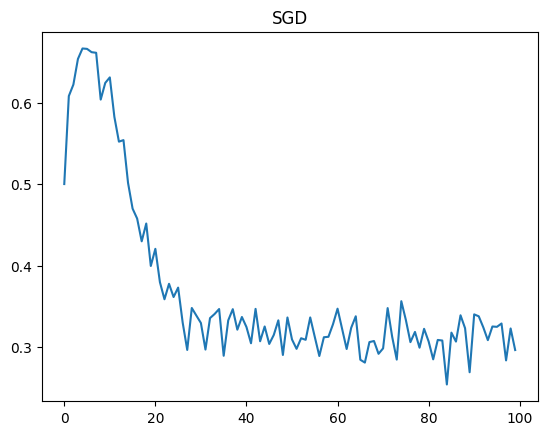

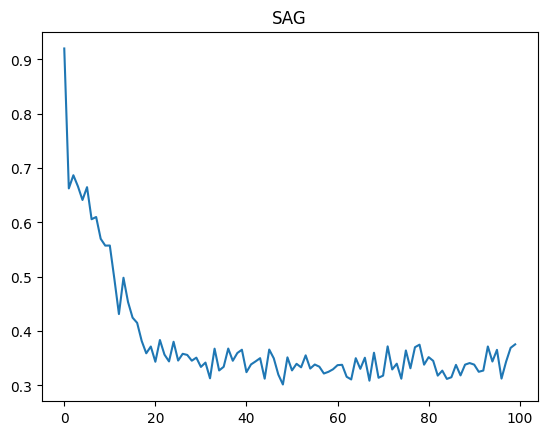

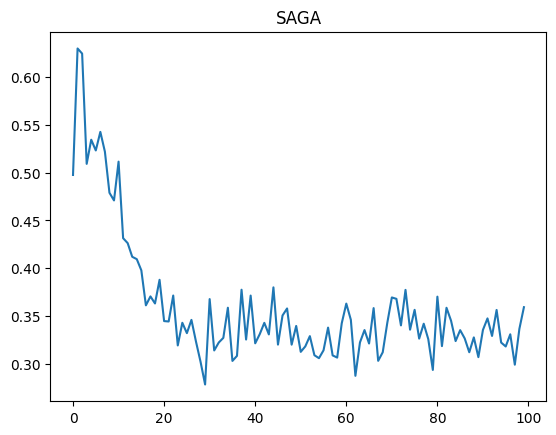

In [251]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import tqdm.notebook as tq
import numpy as np
np.random.seed(0)

# Load the Australian dataset
X, y = load_svmlight_file('australian_scale.txt')
X = X.toarray()
print(type(X))
# Initialize theta and mu
theta = np.zeros(X.shape[1])
mu = 0

# Set the step size and the number of epochs
step_size = 1e-1
lambd = 0.00001
max_iter = int(len(y))
num_epochs = 100


theta_sgd, mu_sgd = theta, mu
theta_sag, mu_sag = theta, mu
theta_saga, mu_saga = theta, mu

# Apply SGD, SAG, and SAGA
objective_values_sgd_lis = []
objective_values_sag_lis = []
objective_values_saga_lis = []
for epoch in tq.tqdm(range(num_epochs)):
    step_size = step_size*(0.99**epoch)
    lambd = step_size
    # np.random.shuffle(X)
    theta_sgd, mu_sgd, obj_val_sgd = SGD(theta_sgd, mu_sgd, X, y, lambd, step_size, max_iter)
    theta_sag, mu_sag, obj_val_sag = SAG(theta_sag, mu_sag, X, y, lambd, step_size, max_iter)
    theta_saga, mu_saga, obj_val_saga = SAGA(theta_saga, mu_saga, X, y, lambd, step_size, max_iter)
    objective_values_sgd_lis.append(obj_val_sgd)
    objective_values_sag_lis.append(obj_val_sag)
    objective_values_saga_lis.append(obj_val_saga)
    

plt.plot(objective_values_sgd_lis, label='SGD')
plt.title('SGD')
plt.show()
plt.plot(objective_values_sag_lis, label='SAG')
plt.title('SAG')
plt.show()
plt.plot(objective_values_saga_lis, label='SAGA')
plt.title('SAGA')
plt.show()

## Q2.
#### 1)
The update rule for $\hat{x_t}(\omega)$:

$$\hat{x_t}(\omega) = x_t - \mu_t \nabla f(x_t, \omega)$$

As we are looking  for the squared difference between updates, subtract $x_t$ from both sides and square the result:

$$(\hat{x_t}(\omega) - x_t)^2 = \mu_t^2 (\nabla f(x_t, \omega))^2$$

Now, take the expectation over $\omega$ on both sides:

$$E_{\omega}[(\hat{x_t}(\omega) - x_t)^2] = E_{\omega}[\mu_t^2 (\nabla f(x_t, \omega))^2]$$

Using properties of variance and expectation $\text{Var}(X) = E[X^2]-(E[X])^2$ which in our case can be used to express the following:
$$
    E_{\omega}[\nabla f(x_t, \omega)^2] = \mu_t^2(\textit{Var}(\nabla f(x_t, \omega))+(E_{\omega}[\nabla f(x_t)])^2)
$$
And simplifying the expected value by $ E_\omega[\nabla f(x_t, \omega)]=\nabla f(x_t) $:
$$
    E_{\omega}[\nabla f(x_t, \omega)^2] = \mu_t^2(\textit{Var}(\nabla f(x_t, \omega))+(\nabla f(x_t))^2)
$$
As the variance of the gradient is less than some constant $c$ $\textit{Var}(\nabla F(x_t)) \leq c$:

$$
\mu_t^2(\textit{Var}(\nabla f(x_t, \omega))+\nabla (f(x_t))^2) \leq \mu_t^2 ((\nabla F(x_t))^2 + c)
$$

So, we have the desired inequality:

$$E_{\omega}[(\hat{x_t}(\omega) - x_t)^2] \leq \mu_t^2 ((\nabla F(x_t))^2 + c)$$

#### 2)

#### 3)